In [1]:
import sys
import os
import pickle
import time
import matplotlib.pyplot as plt

# Add the parent directory to the path
sys.path.append(os.path.abspath('..'))

# Import your modularized code
from order_book.preprocessing import create_order_book_pipeline
from order_book.models import OrderBookEmbeddingModel, OrderBookGradientBoostingModel
from order_book.utils import main, plot_loss_history, create_model

# Define model type - easily switch between models
MODEL_TYPE = "gb"  # Change to "gb" for gradient boosting

# Define file paths
X_train_path = "../data/X_train.parquet"
y_train_path = "../data/y_train.csv"

# Train the model
model, pipeline, history = main(
    X_path=X_train_path,
    y_path=y_train_path,
    batch_size=1000,
    chunk_size=20000,
    n_epochs=1,
    val_split=0.2,
    visualize=False,
    n_samples_to_visualize=0,
    output_dir="../model_checkpoints",
    model_save_dir="../model_checkpoints",
    preprocessed_dir="../data",
    use_existing_preprocessed=False,
    model_type=MODEL_TYPE,
    # Add these parameters to be passed to the model
    model_params={
        "learning_rate": 0.05,       # Lower learning rate for more gradual learning
        "min_data_in_leaf": 20,      # Prevents too specific splits
        "max_depth": 5,              # Reduce depth to prevent overfitting
        "feature_fraction": 0.8,     # Use 80% of features per tree
        "bagging_fraction": 0.8,     # Use 80% of samples per tree
        "bagging_freq": 5,           # Perform bagging every 5 iterations
        "n_estimators": 150          # More trees might help
    }
)

train_losses, val_losses = history['train_loss'], history['val_loss']
plot_loss_history(train_losses, val_losses, title=f"{MODEL_TYPE.upper()} Order Book Model Training History")

Starting training...
Model checkpoints will be saved to ../model_checkpoints
Preprocessing data...
Loading all data for preprocessing...
Loaded all data: X shape=(16080000, 12), y shape=(160800, 2)
Loaded all data: 16080000 timesteps
Fitting preprocessing pipeline...
Filtered out 1 observations with non-positive bid_size values
Creating gb model with 6 venues and 3 actions
Preprocessing all data...
Filtered out 1 observations with non-positive bid_size values
Done.
Finding observations that have labels...
Done
Shuffling and splitting observation IDs in train and validation...
Split data into 128639 training and 32160 validation samples
Creating and saving training data...
Training data saved to ../data\train.parquet
Creating and saving validation data...
Validation data saved to ../data\val.parquet
Creating data generators from preprocessed files...
Preprocessed data contains 128639 observations
Preprocessed data contains 32160 observations

--- Epoch 1/1 ---
Training phase:
Training o

ValueError: too many values to unpack (expected 2)

Selecting a batch of observations for feature importance analysis...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Batch size: 50 observations
Classes in batch: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 16 19 22 23]
Class distribution: {19: 9, 12: 6, 22: 4, 9: 4, 6: 3, 13: 3, 5: 3, 7: 2, 0: 2, 8: 2, 14: 2, 4: 2, 10: 2, 16: 2, 1: 1, 11: 1, 23: 1, 3: 1}
Calculating permutation feature importance (this may take a few minutes)...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━

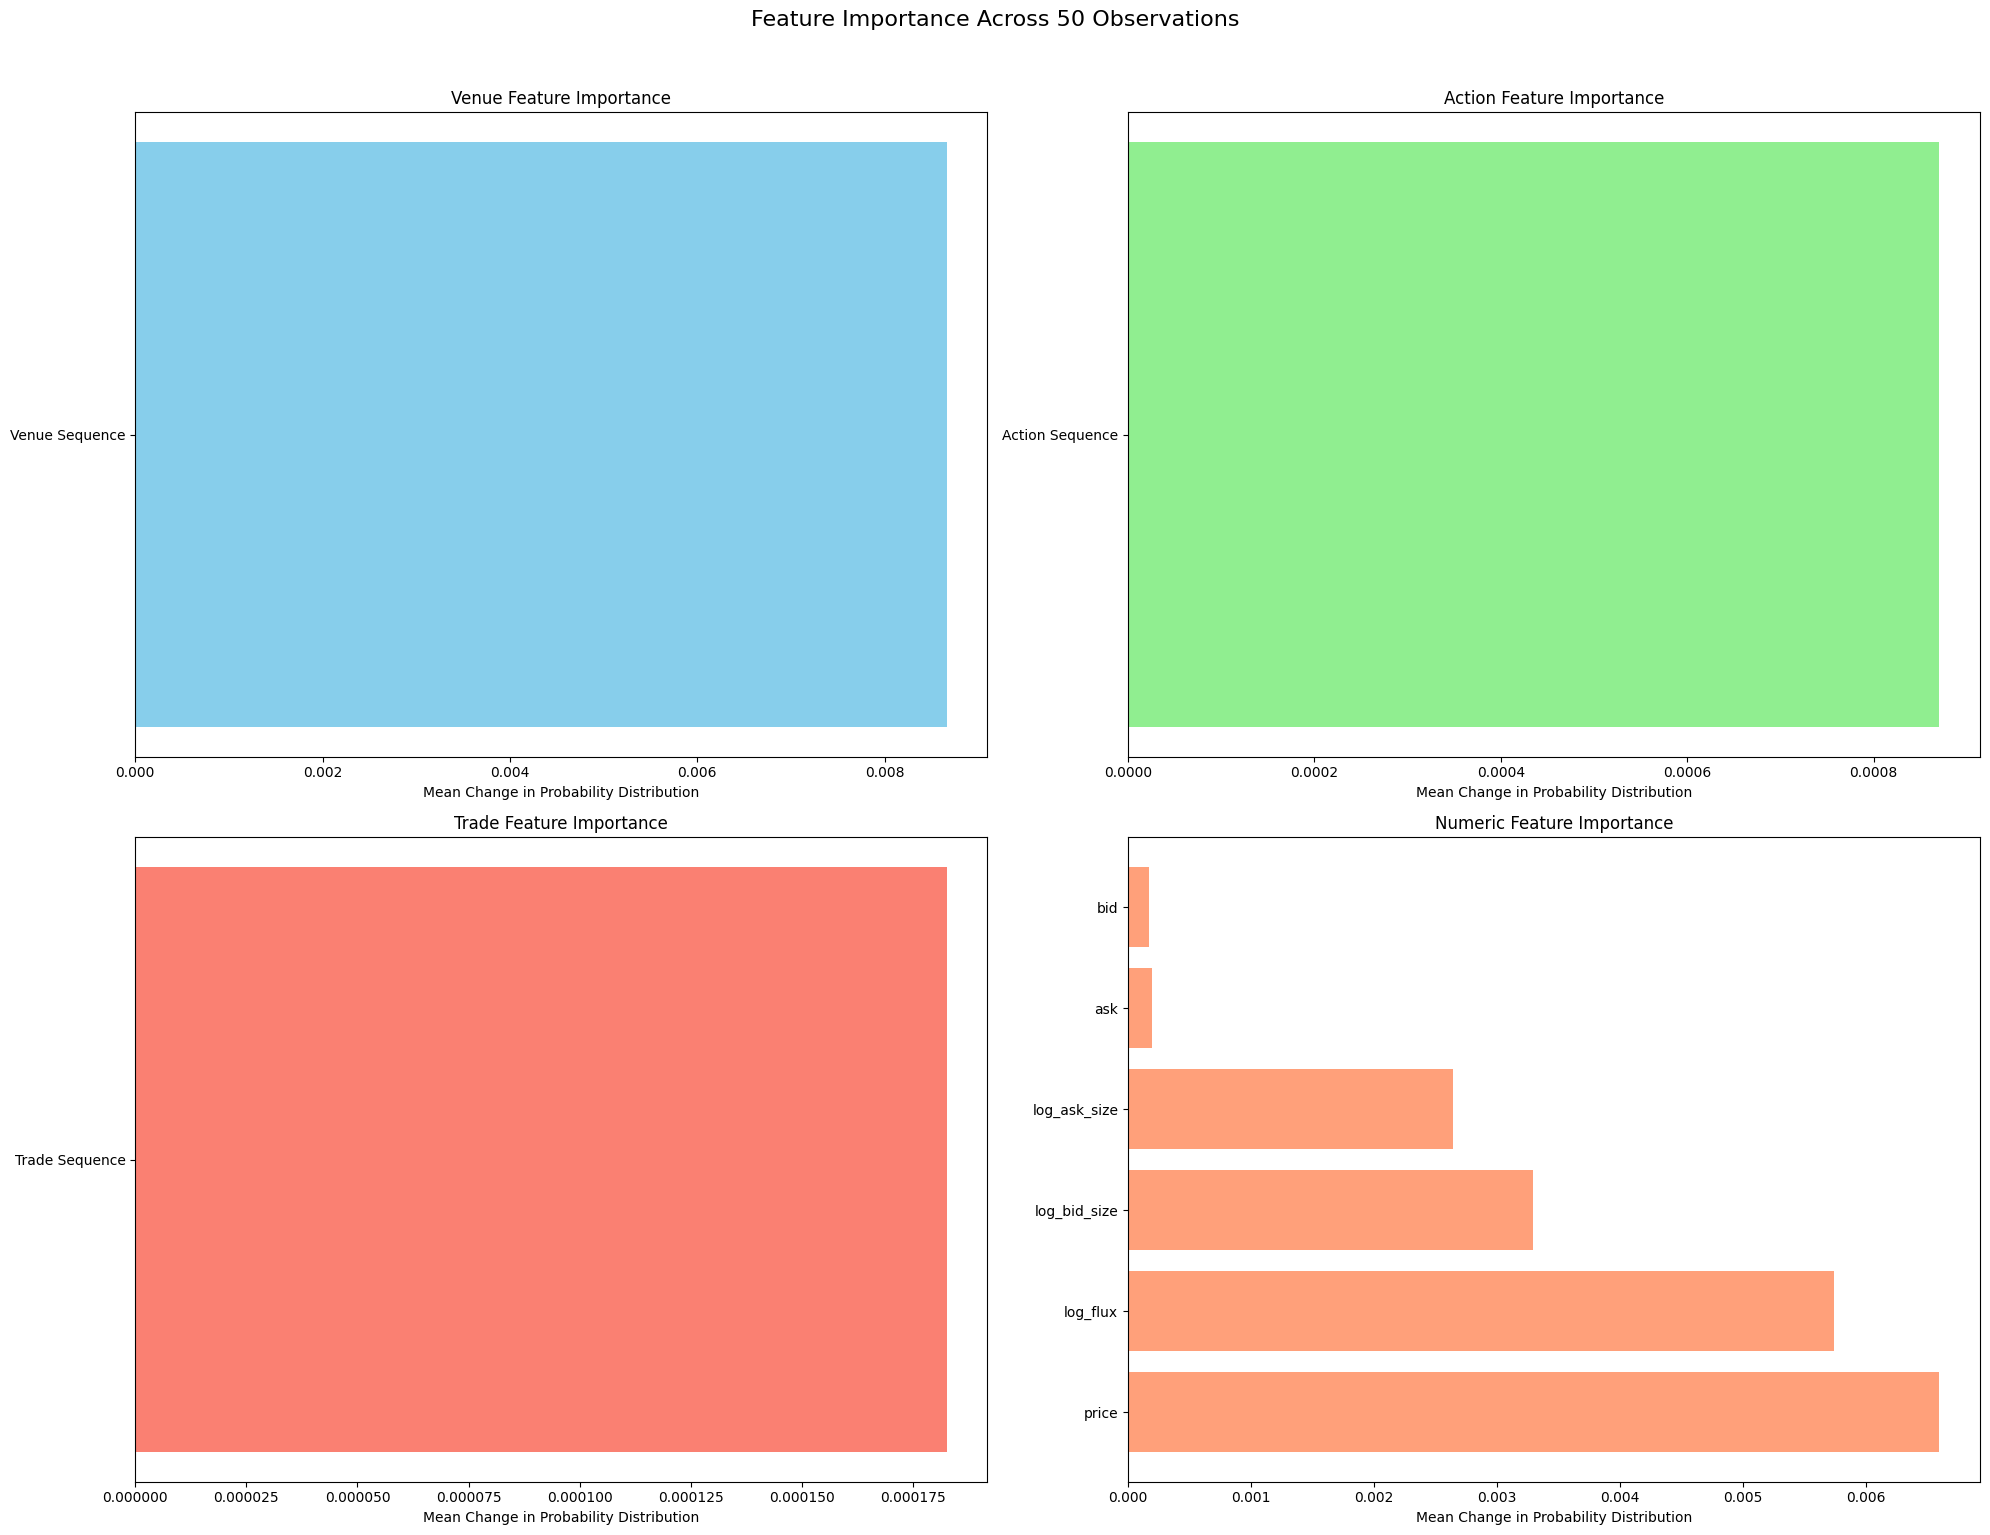

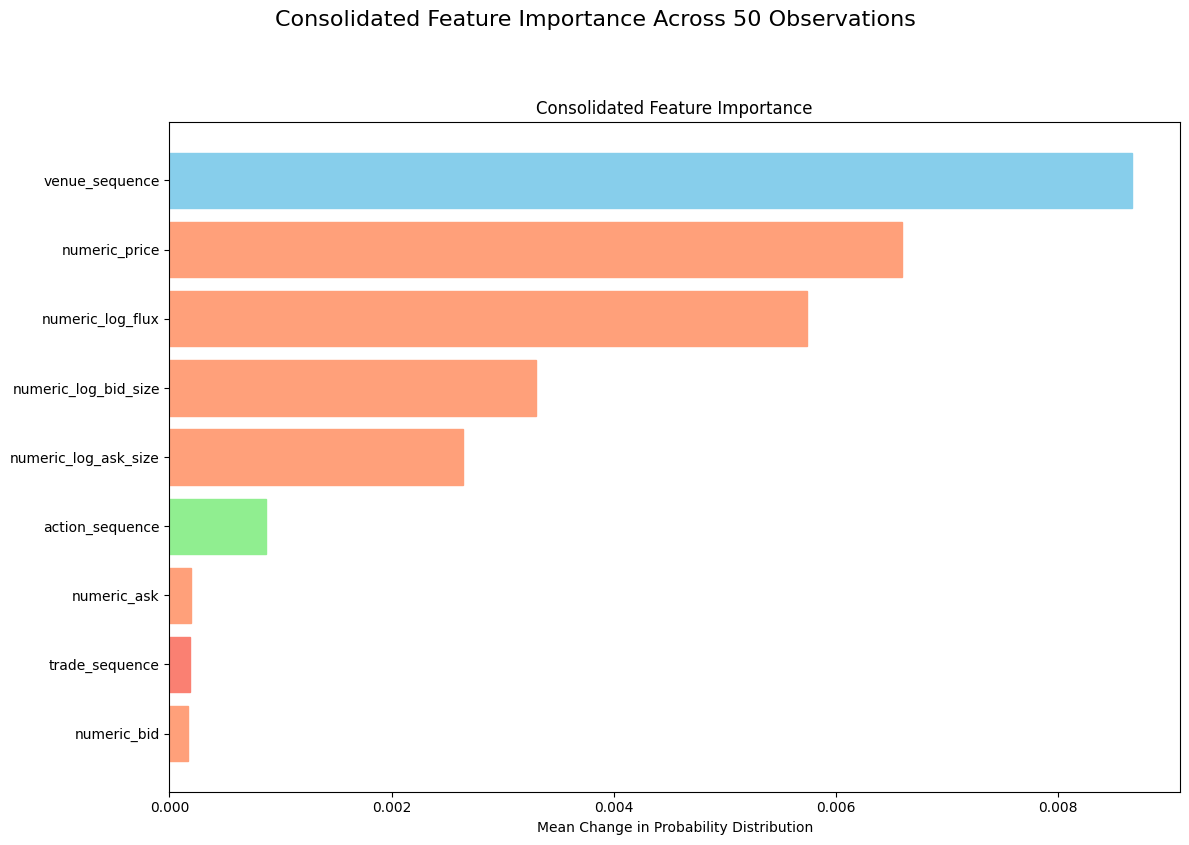

In [3]:
# In your notebook
import pandas as pd
import numpy as np
import pickle
import os
import sys

# Add the project root directory to Python's path
sys.path.append(os.path.abspath(".."))

# Select model type - easily change between "gru" and "gb"
MODEL_TYPE = "gru"  # or "gb" for gradient boosting

# Load the model you want
model_file = f"../model_checkpoints/final_model_{MODEL_TYPE}.pkl"
with open(model_file, "rb") as f:
    checkpoint_data = pickle.load(f)
    model = checkpoint_data['model']
    pipeline = checkpoint_data['pipeline']

# Load test data
X_test = pd.read_parquet("../data/X_test.parquet")

# Sample multiple observations (50) for more robust feature importance
print("Selecting a batch of observations for feature importance analysis...")
num_samples = 50
sample_obs_ids = np.random.choice(X_test['obs_id'].unique(), min(num_samples, len(X_test['obs_id'].unique())), replace=False)
batch_data = X_test[X_test['obs_id'].isin(sample_obs_ids)]

# Process through pipeline
X_batch, obs_ids = pipeline.transform(batch_data)

# Get predictions for the batch
predictions = model.predict(X_batch)
unique_classes = np.unique(predictions)
print(f"Batch size: {len(sample_obs_ids)} observations")
print(f"Classes in batch: {unique_classes}")
print(f"Class distribution: {pd.Series(predictions).value_counts().to_dict()}")

# Calculate permutation feature importance on the batch
print("Calculating permutation feature importance (this may take a few minutes)...")
start_time = time.time()
importance_scores = model.permutation_feature_importance(X_batch, n_repeats=10)
print(f"Permutation importance calculation completed in {time.time() - start_time:.2f} seconds")

# Original detailed visualization (grouped by feature type)
fig = model.visualize_feature_importance(importance_scores, consolidated=False)
plt.figure(fig.number)
plt.suptitle(f"Feature Importance Across {len(sample_obs_ids)} Observations", 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Save the original visualization
fig.savefig(f"feature_importance_batch_{len(sample_obs_ids)}_obs.png", dpi=300, bbox_inches='tight')

# Create consolidated visualization (all features in one plot)
consolidated_fig = model.visualize_feature_importance(importance_scores, consolidated=True)
plt.figure(consolidated_fig.number)
plt.suptitle(f"Consolidated Feature Importance Across {len(sample_obs_ids)} Observations",
             fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Save the consolidated visualization
consolidated_fig.savefig(f"consolidated_feature_importance_{len(sample_obs_ids)}_obs.png", 
                        dpi=300, bbox_inches='tight')

In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import sys

# Add the project root directory to Python's path
sys.path.append(os.path.abspath(".."))

# Load the saved model and pipeline correctly
with open("../model_checkpoints/final_model.pkl", "rb") as f:
    checkpoint_data = pickle.load(f)
    model = checkpoint_data['model']
    pipeline = checkpoint_data['pipeline']

# Define paths
X_test_path = "../data/X_test.parquet"  # Path to test data
output_path = "../data/y_submission.csv"  # Path to save predictions

# Load test data
X_test = pd.read_parquet(X_test_path)

# Get unique observation IDs
observation_ids = X_test['obs_id'].unique()
predictions = []

# Define chunk size
chunk_size = 10000  # Adjust based on your memory constraints and model

# Process observations in chunks
print(f"Processing {len(observation_ids)} observations in chunks of {chunk_size}...")

# Create chunks of observation IDs
chunks = [observation_ids[i:i + chunk_size] for i in range(0, len(observation_ids), chunk_size)]

for chunk_idx, chunk_obs_ids in enumerate(chunks):
    print(f"Processing chunk {chunk_idx+1}/{len(chunks)}")
    
    # Get data for current chunk of observations
    chunk_data = X_test[X_test['obs_id'].isin(chunk_obs_ids)]
    
    # Process the chunk through the pipeline
    # The pipeline returns a tuple: (data_dict, obs_ids)
    X_dict, processed_obs_ids = pipeline.transform(chunk_data)
    
    # Create a mapping to ensure predictions align with original chunk_obs_ids
    obs_id_to_position = {obs_id: i for i, obs_id in enumerate(processed_obs_ids)}
    
    # Make predictions using the model
    chunk_predictions = model.predict(X_dict, explain=True, visualize=True)
    
    # Store results, ensuring we have the right observation IDs
    for i, obs_id in enumerate(processed_obs_ids):
        if obs_id in chunk_obs_ids:  # Just a safety check
            predictions.append((obs_id, int(chunk_predictions[i])))

# Create submission DataFrame
submission_df = pd.DataFrame(predictions, columns=['obs_id', 'eqt_code_cat'])

# Save to CSV
submission_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Processing 81600 observations in chunks of 10000...
Processing chunk 1/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step
Processing chunk 2/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step
Processing chunk 3/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step
Processing chunk 4/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step
Processing chunk 5/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step
Processing chunk 6/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step
Processing chunk 7/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step
Processing chunk 8/9
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step
Processing chunk 9/9
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
Predictions saved to ../data/y_submission.csv


In [ ]:
# Add this to a cell in project.ipynb
import sys
import os
import nest_asyncio
import uvicorn
from threading import Thread
import time
from pyngrok import ngrok

# Add project root to path if needed
if not os.path.abspath('..') in sys.path:
    sys.path.append(os.path.abspath('..'))

# Import your FastAPI app
from api.main import app

# Apply nest_asyncio to allow running asyncio in notebook
nest_asyncio.apply()

# Function to run the server in a separate thread
def run_server_in_thread(port=8000):
    uvicorn.run(app, host="0.0.0.0", port=port)

# Create a function to start/stop server with optional ngrok
def start_api_server(port=8000, use_ngrok=False, ngrok_token=None):
    global server_thread, public_url
    
    # Configure ngrok if needed
    if use_ngrok:
        if ngrok_token:
            ngrok.set_auth_token(ngrok_token)
        public_url = ngrok.connect(port)
        print(f"📡 Public URL: {public_url}")
        
    # Start server in a thread
    server_thread = Thread(target=run_server_in_thread, args=(port,), daemon=True)
    server_thread.start()
    
    # Wait for server startup
    time.sleep(1)
    print(f"🚀 API server running at http://localhost:{port}")
    print(f"📚 API documentation at http://localhost:{port}/docs")
    
    return server_thread

# Function to stop the server
def stop_api_server():
    # Disconnect ngrok tunnels
    try:
        ngrok.disconnect_all()
        print("📡 Ngrok tunnel closed")
    except:
        pass
    
    print("🛑 API server stopping - notebook kernel will need to be restarted")
    # To fully stop the server, you'll need to restart the kernel

# Start the API server
server_thread = start_api_server(port=8000, use_ngrok=False)